In [22]:
import numpy as np
# from joblib import Parallel, delayed
from os.path import exists
import matplotlib.pyplot as plt

from assignment.util import *
from assignment.TSP import *
from assignment.cooling import *
from assignment.SAMinimizer import *

In [2]:
# logging.basicConfig(level = logging.DEBUG)

In [3]:
cost_eil51, cost_a280, cost_pcb442 = map(first, COST_FUNCTION_PAIRS)
delta_cost_eil51, delta_cost_a280, delta_cost_pcb442 = map(second, COST_FUNCTION_PAIRS)

In [4]:
_, a280_tour = read_tour(OPT_TOUR_FILES[1])
cost_a280(a280_tour)

2586.7696475631606

In [5]:
np.random.seed(0xc0ffee)
cost_function = cost_a280
delta_cost_function = delta_cost_a280
n = delta_cost_function.D.shape[0]
print(n)
T_initial = 100.0
T_final = 0.1

cr = 0.95
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt

sim_anneal_system = SAMinimizer(
    mkov_transition,
    delta_cost_a280,
    cooling_schedule,
    np.random.uniform,
    state_constructor)

X0 = np.random.permutation(n)
print(X0)

280
[128 103 205  42  64 180  74 110  50  39 225 264 224   2  81 133 100  80
 257 260 176 113 251   8 130 136  17  65 242  25 263   5  93  68  27 239
 155  96 151 279 204  72   6 275  28 132  12  88 109  40 259  34 129 201
  23 241 221 262 145 166 249  94 134 267 209  76 117  45 139  33   9  69
  90 215 219  91  84 148  98 193 268 168 146 220  51   1 178 227 248 254
 208 234 163  92 237  56  24  61 232 228  26 112 274  21  67 230 141 233
 188 186 191  22  87 144  47 190  70 152 258  62  89 194 162 124 149 211
 158 197 138 140  86 159  11  52 183 222 114 250   7 125  57 214 156 218
 238  48 247  18  66 157 160 202   3 121 212  95 143 107 171 192  54 118
 187  19 147 131 199  14 175 119 213  77 246 244   4  15 165 252  97 206
  49 210 240 142  31 278 273 198 115 223  82  59 195 189 216  29 266 200
 122 203 153 243 135 108  73 126  16 120  44 179 150  30 127 261 174 123
  55 184 181  78 106  38 277  58  43 253  46 207 137 272 265  71 245  20
 235 173 177 231 256 111 170 276  99 161 172  1

In [6]:
sim_anneal_system.run(1000, T_initial, X0, cost_a280, StoppingCriterion.MIN_TEMPERATURE, CostProbing.LATEST_GLOBAL_OPTIMUM, T_final)

In [7]:
print(sim_anneal_system.min_cost)

3221.020789518919


In [8]:
NODE_COUNTS = np.array([51, 280, 442])

## Effect of Temperature on Initial Acceptance Rate

In [9]:
def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
    acceptance_rates = np.full(batch_size, np.float64("nan"))
    min_costs = np.full(batch_size, np.float64("nan"))
    node_count = sa_system.delta_cost.D.shape[0]
    for i in range(batch_size):
        X0 = np.random.permutation(node_count)
        sa_system.run(chain_length, T_initial, X0, *args)
        min_costs[i] = sa_system.min_cost
        acceptance_rates[i] = np.float64(sa_system.acceptance_count)/chain_length
        sa_system.reset()
        
    return min_costs, acceptance_rates

In [30]:
# eil51
cost_function, dcost_function = COST_FUNCTION_PAIRS[0]
node_count = cost_function.D.shape[0] 
print(node_count)
cr = 0.95
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt


c_values = np.linspace(1,10, 10)
T_initial_values = c_values * np.sqrt(node_count)


# for parallelization
N_JOBS = 6

rngs = generate_rngs(len(T_initial_values))

batch_size = 10
min_costs_list = []
chain_length = 1000
chain_count = 100
args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)


sa_systems = [SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)
                for rng in rngs]

min_cost_list = []
acceptance_rates_list = []
npz_filename = "test.npz"
npz_savepath = save_path(npz_filename)


if not exists(npz_filepath):
    # TODO: parallelize this loop
    for i,T0 in enumerate(T_initial_values):
        min_costs, acceptance_rates = run_batch(sa_systems[i], batch_size, chain_length, T0, *args)
        min_cost_list.append(min_costs)
        acceptance_rates_list.append(acceptance_rates)
    min_cost_list = np.array(min_cost_list)
    acceptance_rates_list = np.array(acceptance_rates_list)

else:
    save_data = np.load(npz_savepath)
    min_cost_list, acceptance_rates_list = save_data['arr_0'], save_data['arr_1']


51


In [31]:
print(acceptance_rates_list)

[[0.241 0.238 0.257 0.227 0.255 0.247 0.203 0.227 0.239 0.214]
 [0.416 0.392 0.418 0.411 0.444 0.429 0.413 0.462 0.434 0.434]
 [0.556 0.564 0.552 0.545 0.566 0.604 0.578 0.605 0.579 0.568]
 [0.669 0.682 0.671 0.64  0.675 0.643 0.667 0.652 0.671 0.68 ]
 [0.731 0.734 0.743 0.766 0.743 0.69  0.71  0.744 0.74  0.734]
 [0.752 0.784 0.77  0.756 0.763 0.757 0.782 0.788 0.768 0.765]
 [0.818 0.818 0.798 0.813 0.847 0.823 0.823 0.796 0.782 0.805]
 [0.832 0.814 0.827 0.844 0.817 0.834 0.825 0.854 0.818 0.843]
 [0.843 0.859 0.849 0.859 0.855 0.83  0.85  0.85  0.848 0.855]
 [0.862 0.86  0.871 0.862 0.867 0.857 0.855 0.877 0.861 0.864]]


In [32]:
abs_min_costs = np.min(min_cost_list, axis = 1)
mean_acceptance_rates = np.mean(acceptance_rates_list, axis = 1)

In [26]:
min_cost_list.shape

(10, 10)

In [42]:
np.min(abs_min_costs)

435.0180038665094

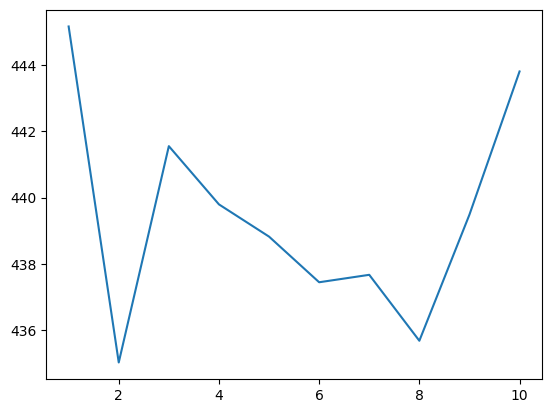

In [40]:
plt.plot(c_values, abs_min_costs)
plt.show()

In [39]:
[cooling_schedule(T0, chain_count) for T0 in T_initial_values]

[0.04228103568611185,
 0.0845620713722237,
 0.12684310705833554,
 0.1691241427444474,
 0.21140517843055925,
 0.2536862141166711,
 0.29596724980278294,
 0.3382482854888948,
 0.38052932117500665,
 0.4228103568611185]